# XSOSI Annual Report

This is an annual report for XSOSI from 2022.6 to 2023.6.

In [1]:
var openDigger = require('../../src/open_digger');
var now = new Date();
var startYear = 2022, startMonth = 7, endYear = 2023, endMonth = 6;
var forEveryMonth = f => {
    var index = 0;
    for (var y = startYear; y <= endYear; y++)
        for (var m = (y === startYear ? startMonth : 1); m <= (y === endYear ? endMonth : 12); m++)
            f(y, m, index++);
};
var repoIds = [288431943, 470364208, 467768946, 461374162, 471252840, 477937218, 428629051, 262909684, 221379769, 259035151, 358757145, 502755745, 508325123, 533339106, 572845686, 639923640 ];
var monthes = [];
forEveryMonth((y, m) => monthes.push(`${y}-${m}`));
var getEmptyArray = () => new Array(12).fill(0);

In [2]:
var https = require('https');
var getData = async (name, type) => {
    return new Promise(resolve => {
        https.get(`https://oss.x-lab.info/open_digger/github/${name}/${type}.json`, resp=>{
            let data = '';
            resp.on('data', chunk => data += chunk);
            resp.on('end', () => resolve(JSON.parse(data)));
        }).on("error", err => resolve([]));
    });
};

In [3]:
var repoCountTrend = getEmptyArray();
var activityTrend = getEmptyArray();
var starsTrend = getEmptyArray();
var openrankTrend = getEmptyArray();
var participantsTrend = getEmptyArray();
var averageOpenRankTrend = getEmptyArray();
var averageActivityTrend = getEmptyArray();
var openrankDetails = new Map();

openDigger.driver.clickhouse.query(`SELECT repo_id, argMax(repo_name, created_at) FROM gh_repo_openrank WHERE repo_id IN (${repoIds.join(',')}) GROUP BY repo_id`).then(async data => {
    var repos = data.map(row => row[1]);
    var activity = await Promise.all(repos.map(n => getData(n, 'activity')));
    var stars = await Promise.all(repos.map(n => getData(n, 'stars')));
    var openrank = await Promise.all(repos.map(n => getData(n, 'openrank')));
    var participants = await Promise.all(repos.map(n => getData(n, 'participants')));
    
    forEveryMonth((y, m, i) => {
        var key = `${y}-${m.toString().padStart(2, '0')}`;
        activity.forEach(r => { repoCountTrend[i] += r[key] ? 1 : 0; activityTrend[i] += r[key] ?? 0; } );
        stars.forEach(r => starsTrend[i] += r[key] ?? 0);
        openrank.forEach(r => openrankTrend[i] += r[key] ?? 0);
        participants.forEach(r => participantsTrend[i] += r[key] ?? 0);
    });
    
    averageOpenRankTrend = openrankTrend.map((o, i) => o / repoCountTrend[i]);
    averageActivityTrend = activityTrend.map((o, i) => o / repoCountTrend[i]);
});
    
    
var details = JSON.parse(fs.readFileSync('./detail.json'));
forEveryMonth((y, m, i) => {
    details[`${y}-${m}`].total.forEach(d => {
        if (!openrankDetails.has(d.login)) openrankDetails.set(d.login, getEmptyArray());
        openrankDetails.get(d.login)[i] += d.openrank;
    });
});

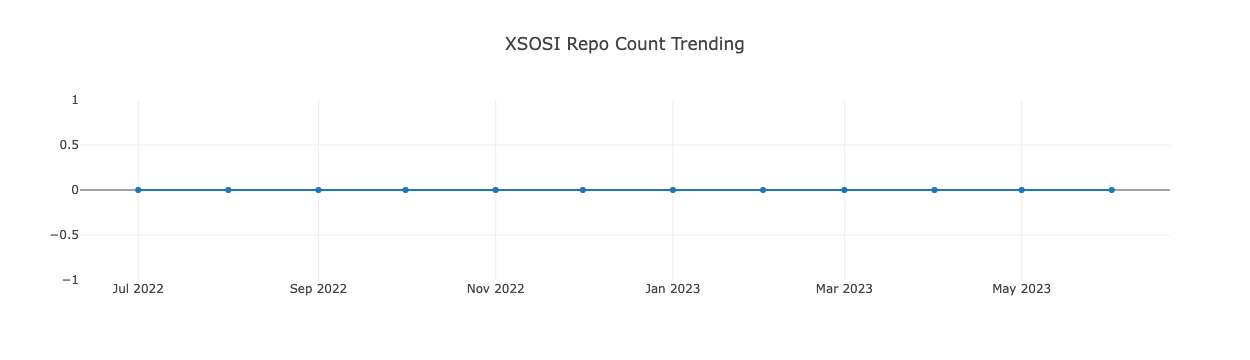

In [4]:
openDigger.render.plotly([{ x: monthes, y: repoCountTrend, type: 'scatter' }], { title: 'XSOSI Repo Count Trending' });

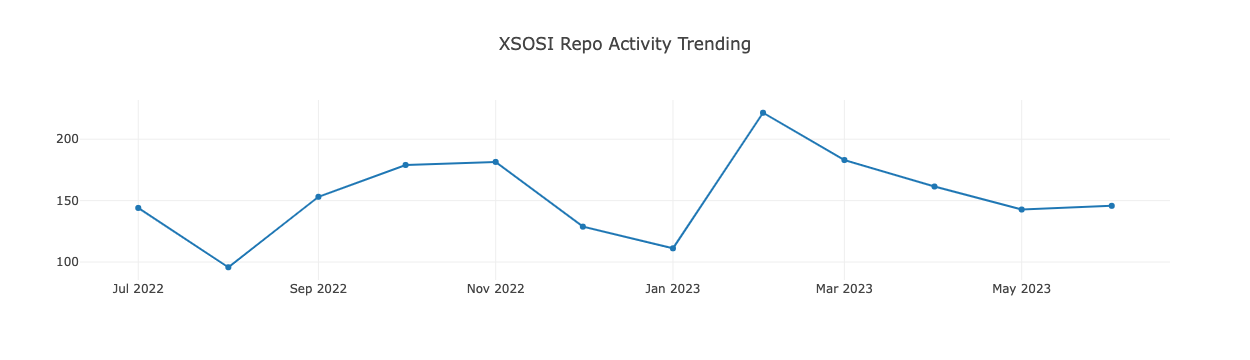

In [5]:
openDigger.render.plotly([{ x: monthes, y: activityTrend, type: 'scatter' }], { title: 'XSOSI Repo Activity Trending' });

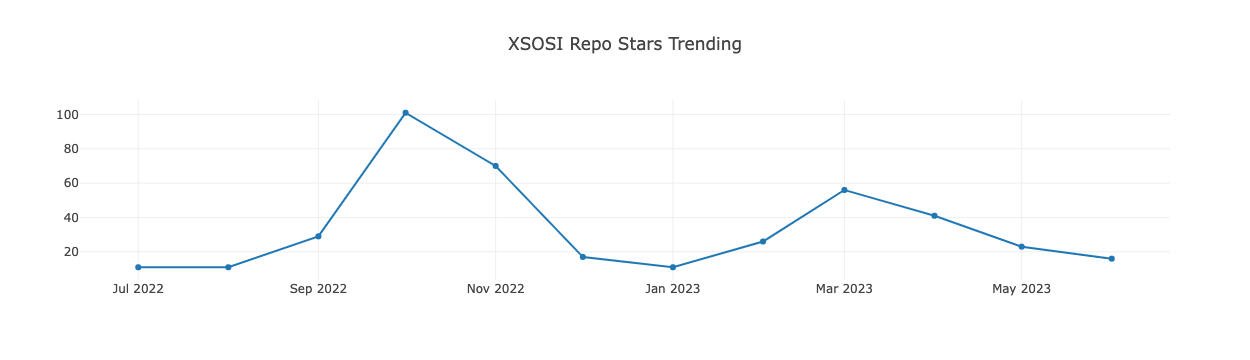

In [6]:
openDigger.render.plotly([{ x: monthes, y: starsTrend, type: 'scatter' }], { title: 'XSOSI Repo Stars Trending' });

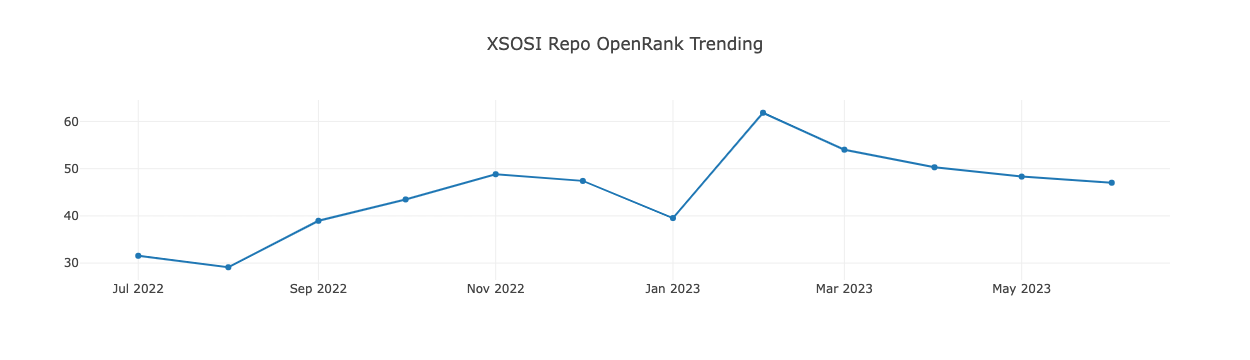

In [7]:
openDigger.render.plotly([{ x: monthes, y: openrankTrend, type: 'scatter' }], { title: 'XSOSI Repo OpenRank Trending' });

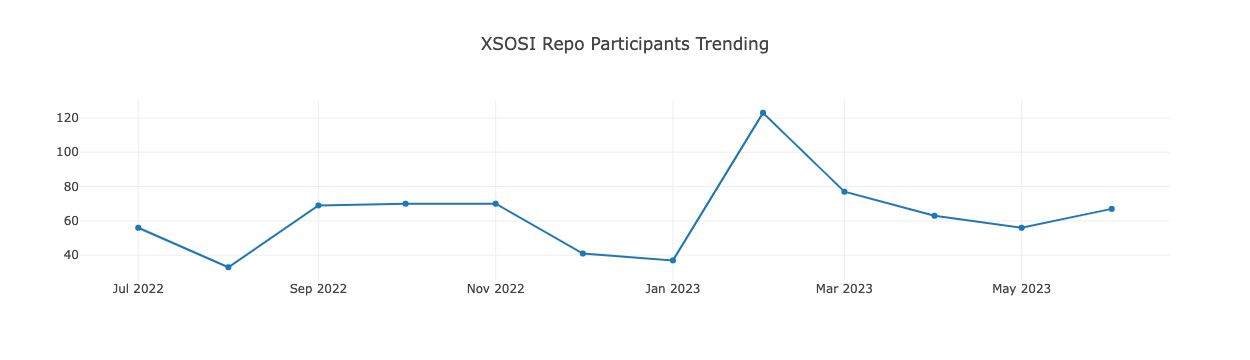

In [8]:
openDigger.render.plotly([{ x: monthes, y: participantsTrend, type: 'scatter' }], { title: 'XSOSI Repo Participants Trending' });

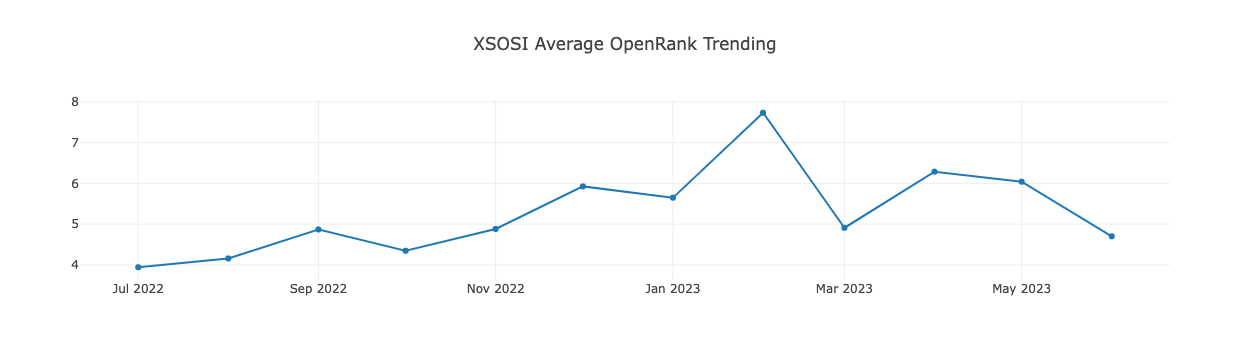

In [9]:
openDigger.render.plotly([{ x: monthes, y: averageOpenRankTrend, type: 'scatter' }], { title: 'XSOSI Average OpenRank Trending' });

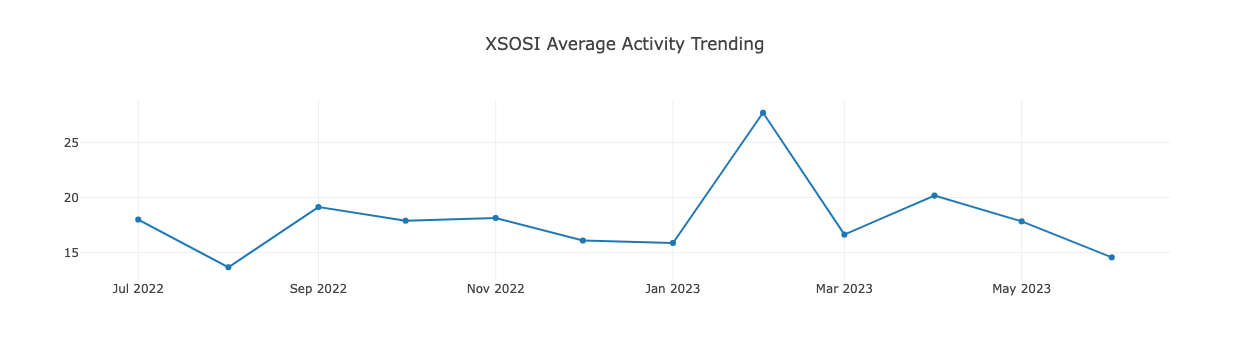

In [10]:
openDigger.render.plotly([{ x: monthes, y: averageActivityTrend, type: 'scatter' }], { title: 'XSOSI Average Activity Trending' });

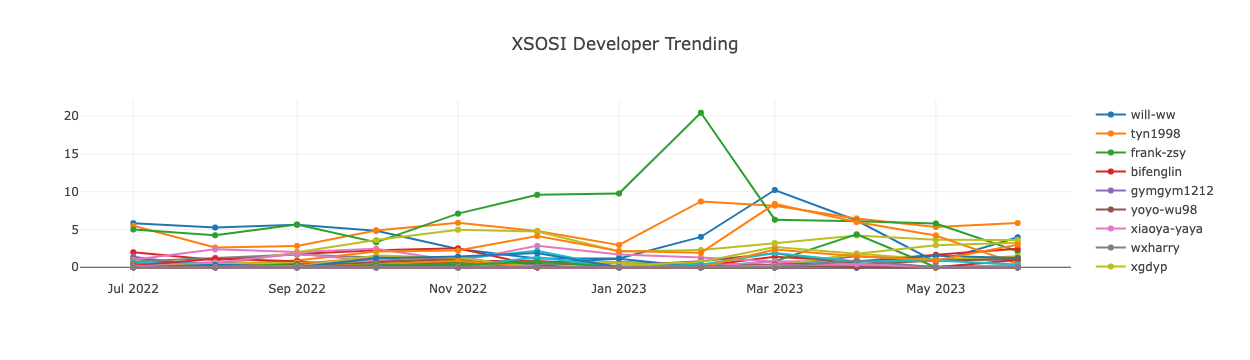

In [11]:
openDigger.render.plotly(Array.from(openrankDetails.entries()).map(i => {
    return {
        x: monthes,
        y: i[1],
        type: 'scatter',
        name: i[0],
    };
}), { title: 'XSOSI Developer Trending' });